In [1]:
import pystan

In [2]:
from numpy import *
Nobs = 208
x_true = random.uniform(0,10, size=Nobs)
y_true = random.uniform(-1,1, size=Nobs)
alpha_true = 0.5
beta_x_true = 1.0
beta_y_true = 10.0
eps_true = 0.5
z_true = alpha_true + beta_x_true*x_true + beta_y_true*y_true
z_obs = z_true + random.normal(0, eps_true, size=Nobs)

Text(0, 0.5, 'Z')

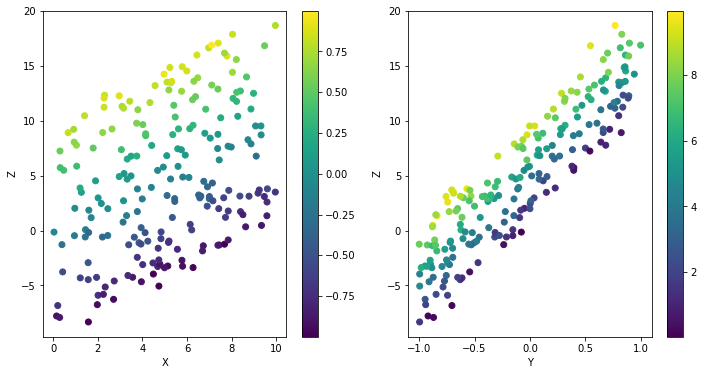

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x_true, z_obs, c=y_true, marker='o')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Z')
plt.subplot(1,2,2)
plt.scatter(y_true, z_obs, c=x_true, marker='o')
plt.colorbar()
plt.xlabel('Y')
plt.ylabel('Z')

In [4]:
model = """
data {
   int<lower=4> N; // Number of data points
   real x[N];      // the 1st predictor
   real y[N];      // the 2nd predictor
   real z[N];      // the outcome
}
parameters {
   real alpha;     // intercept
   real betax;     // x-slope
   real betay;     // y-slope
   real<lower=0> eps;       // dispersion
}
model {
   for (i in 1:N)
      z[i] ~ normal(alpha + betax * x[i] + betay * y[i], eps);
}"""

In [5]:
data = {'N':Nobs, 'x':x_true, 'y':y_true, 'z':z_obs}

In [6]:
#fit = pystan.stan(model_code=model, data=data, iter=1000, chains=4)

In [7]:
#print(fit)

In [8]:
#p = fit.plot()

In [9]:
sm = pystan.StanModel(model_code=model); # compile model
fit = sm.sampling(data=data, iter=3000, warmup =2000, chains=4) # perform sampling

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a87850813aab96ee1be5112f40cf12e0 NOW.


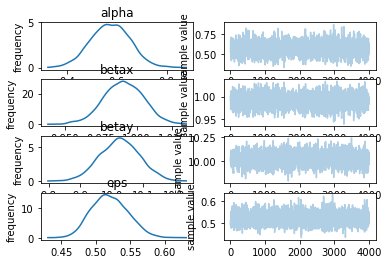

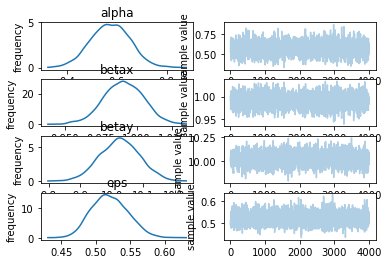

In [10]:
fit.plot()

In [11]:
print(fit.stansummary())

Inference for Stan model: anon_model_a87850813aab96ee1be5112f40cf12e0.
4 chains, each with iter=3000; warmup=2000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   0.57  1.6e-3   0.08   0.42   0.52   0.57   0.63   0.73   2276    1.0
betax   0.99  2.9e-4   0.01   0.96   0.98   0.99    1.0   1.02   2291    1.0
betay  10.03  1.1e-3   0.06   9.91   9.98  10.03  10.07  10.15   3111    1.0
eps     0.52  4.6e-4   0.03   0.47    0.5   0.52   0.54   0.57   3305    1.0
lp__   31.81    0.04   1.44   28.2  31.07  32.12  32.87  33.62   1641    1.0

Samples were drawn using NUTS at Sat Jan 23 14:16:53 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [21]:
lin_reg_code = """
data {
    int<lower=0> n;
    real x[n];
    real y[n];
}
transformed data {}
parameters {
    real a;
    real b;
    real sigma;
}
transformed parameters {
    real mu[n];
    for (i in 1:n) {
        mu[i] <- a*x[i] + b;
        }
}
model {
    sigma ~ uniform(0, 20);
    y ~ normal(mu, sigma);
    a ~ normal(9.1, 10);
    b ~ normal(1, 10);
}
generated quantities {}
"""

n = 200
_a = 6
_b = 2
x = linspace(0, 1, n)
y = _a*x + _b + random.randn(n)

lin_reg_dat = {
             'n': n,
             'x': x,
             'y': y
            }

fit = pystan.stan(model_code=lin_reg_code, data=lin_reg_dat, iter=5000, warmup =2000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_77f71e9fe14f33b7edbfa0f5fb185073 NOW.


In [23]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_77f71e9fe14f33b7edbfa0f5fb185073.
4 chains, each with iter=5000; warmup=2000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=12000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a        5.86  3.5e-3   0.25   5.37   5.69   5.86   6.02   6.34   5107    1.0
b        2.19  2.0e-3   0.14   1.91    2.1   2.19   2.29   2.47   5037    1.0
sigma    1.01  6.9e-4   0.05   0.92   0.98   1.01   1.04   1.12   5555    1.0
mu[1]    2.19  2.0e-3   0.14   1.91    2.1   2.19   2.29   2.47   5037    1.0
mu[2]    2.22  2.0e-3   0.14   1.94   2.13   2.22   2.32    2.5   5044    1.0
mu[3]    2.25  2.0e-3   0.14   1.97   2.16   2.25   2.34   2.53   5052    1.0
mu[4]    2.28  2.0e-3   0.14    2.0   2.19   2.28   2.37   2.56   5059    1.0
mu[5]    2.31  1.9e-3   0.14   2.03   2.22   2.31    2.4   2.58   5067    1.0
mu[6]    2.34  1.9e-3   0.14   2.07   2.25   2.34   2.43   2.61   50

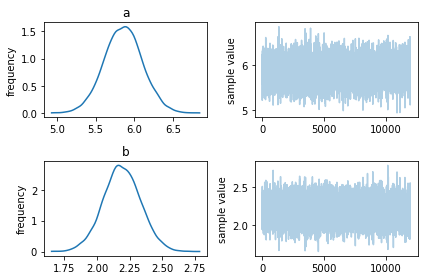

In [24]:
fit.plot(['a', 'b']);
plt.tight_layout()

In [20]:
print('data { \n\
   int<lower=0> N;')
for i in range(4):
    print('   real x'+str(i)+'[N];' + ' \\\\ predictor #' + str(i))
print('}')

data { 
   int<lower=0> N;
   real x0[N]; \\ predictor #0
   real x1[N]; \\ predictor #1
   real x2[N]; \\ predictor #2
   real x3[N]; \\ predictor #3
}


In [22]:
print('transformed data {}')

transformed data {}


In [23]:
print('parameters {')
for i in range(4):
    print('   real beta'+str(i)+'[N];' + ' \\\\ coefficient #' + str(i))
print('}')

parameters {
   real beta0[N]; \\ coefficient #0
   real beta1[N]; \\ coefficient #1
   real beta2[N]; \\ coefficient #2
   real beta3[N]; \\ coefficient #3
}


In [24]:
print('transformed parameters {}')

transformed parameters {}


In [25]:
print('model {}')

model {}
